In [1]:
import cv2
# import Libraries
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, GlobalAveragePooling2D, multiply, Lambda, Dropout,BatchNormalization, Attention, Input, Multiply
from tensorflow.python.ops.init_ops import he_normal
from keras.backend import concatenate
from keras.callbacks import EarlyStopping
import keras.backend as K

In [2]:
# Define paths
train_dir = 'D:/deep_space/MV/Dataset_split_3/Train'
test_dir = 'D:/deep_space/MV/Dataset_split_3/Test'

In [3]:
# Load and preprocess the training data
input_shape = (256,256, 3)
batch_size=16

# Load and preprocess the test data
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=[0.64, 1.0],
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.177)

'''
                                   rotation_range=20,  # 随机旋转图像（0-180度之间）
                                   width_shift_range=0.2,  # 随机水平平移图像
                                   height_shift_range=0.2,  # 随机垂直平移图像
                                   shear_range=0.2,  # 随机错切变换
                                   zoom_range=0.2,  # 随机缩放图像
                                   horizontal_flip=True,  # 随机水平翻转图像
                                   fill_mode='nearest',  # 用于填充新创建像素的方法
                                   brightness_range=[0.5, 1.5],
'''

                                   


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)


Found 274 images belonging to 4 classes.
Found 57 images belonging to 4 classes.


In [4]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 60 images belonging to 4 classes.


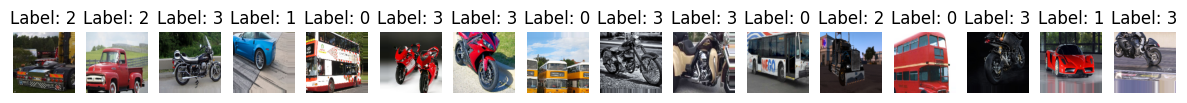

In [5]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [6]:
def first_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    
    att = Attention()([x, x])
    x = x + att
    
    return x


In [7]:
def second_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same", kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='same')(x)
    
      
    att = Attention()([x, x])
    x = x + att
    
    return x


In [8]:
def create_combined_model(input_shape=input_shape):
    inputs = Input(shape=input_shape)
    
    branch1 = first_Model(inputs)
    branch2 = second_Model(inputs)
    
    x = concatenate([branch1, branch2], axis=-1)
    
    
    att = Attention()([x, x])
    x = x + att
    x = Conv2D(4096, (1,1), activation='relu')(x)

    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    output = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage

combined_model = create_combined_model(input_shape)

In [9]:
#computing attention weights. Each element in the input tensor x will be assigned a weight by this dense layer
# attention = Dense(1, activation='tanh')(x)

In [10]:
# Reshape attention to have dimensions (-1, 1, 1)
# attention = Reshape((-1, 1, 1))(attention)

In [11]:
# Apply the attention weights element-wise to the original feature representation (x) 
# attention = multiply([x, attention])

In [12]:
# The attention weights are summed along the channel axis (-2) to produces a single attention value 
# attention = Lambda(lambda x: K.sum(x, axis=-2))(attention)

In [13]:
# The attention values are expanded along a new axis (-1)
# attention = Lambda(lambda x: K.expand_dims(x, axis=-1))(attention)

In [14]:
# computes the average of all the values along each channel
# attention = GlobalAveragePooling2D()(attention)

In [15]:
# merged = Dense(4, activation='softmax')(attention)

In [16]:
# Create the new model
# model = Model(inputs=base_model.input, outputs=merged)
# model = Model(inputs=base_model.input, outputs=output)

In [17]:

def custom_categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-10
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
    return tf.reduce_mean(loss)


In [18]:
# Display the model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [19]:

# Compile the model
combined_model.compile(optimizer='Adam', 
              loss=custom_categorical_crossentropy, 
              metrics=['accuracy']
              )

In [20]:
# Train the model
history = combined_model.fit(train_generator, validation_data=(val_generator), epochs=100)

Epoch 1/100
18/18 [==============================] - 28s 1s/step - loss: 4.1614 - accuracy: 0.2555 - val_loss: 1.3864 - val_accuracy: 0.2632
Epoch 2/100
18/18 [==============================] - 25s 1s/step - loss: 1.3762 - accuracy: 0.3066 - val_loss: 1.3825 - val_accuracy: 0.2456
Epoch 3/100
18/18 [==============================] - 25s 1s/step - loss: 1.3706 - accuracy: 0.3540 - val_loss: 1.3719 - val_accuracy: 0.2456
Epoch 4/100
18/18 [==============================] - 25s 1s/step - loss: 1.3737 - accuracy: 0.3029 - val_loss: 1.3453 - val_accuracy: 0.4035
Epoch 5/100
18/18 [==============================] - 25s 1s/step - loss: 1.3449 - accuracy: 0.3467 - val_loss: 1.3060 - val_accuracy: 0.3333
Epoch 6/100
18/18 [==============================] - 25s 1s/step - loss: 1.2798 - accuracy: 0.3942 - val_loss: 1.2472 - val_accuracy: 0.4035
Epoch 7/100
18/18 [==============================] - 25s 1s/step - loss: 1.2705 - accuracy: 0.4234 - val_loss: 1.2290 - val_accuracy: 0.4386
Epoch 8/100
1

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = combined_model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

18/18 [==============================] - 17s 927ms/step - loss: 0.2886 - accuracy: 0.8978
Test Accuracy: 0.8978102207183838
Test loss: 0.2886330783367157


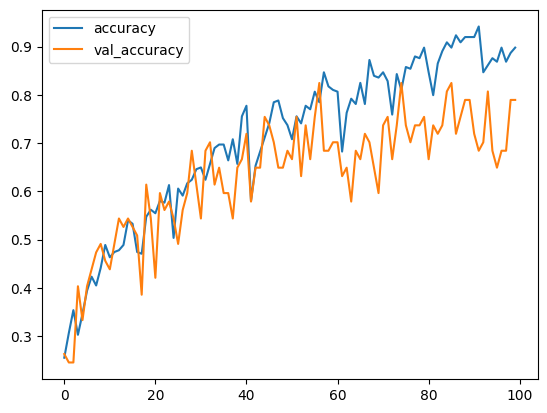

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

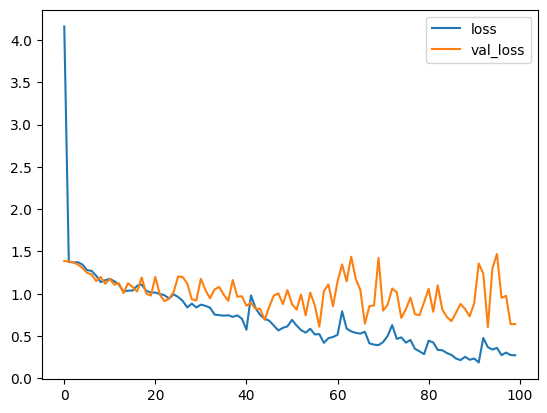

In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [24]:
combined_model.save("model.h5")